In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from exp.nb_02 import *
import torch.nn.functional as F

In [3]:
x_train,y_train,x_valid,y_valid = get_data_normalized()
x_train.mean(),x_train.std(),x_train.max(),x_train.min()
x_valid.mean(),x_valid.std(),x_valid.max(),x_valid.min()

(tensor(-4.3871e-06), tensor(1.), tensor(2.3301), tensor(-0.5479))

(tensor(-0.0205), tensor(0.9801), tensor(2.3301), tensor(-0.5479))

In [4]:
# torch.nn.modules.conv._ConvNd.reset_parameters??

In [5]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50
n,m,c,nh

(60000, 784, tensor(10), 50)

# Create model using nn.module + log softmax + cross entropy

In [14]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [15]:
model = Model(m,nh,c.tolist())
pred = model(x_train)

In [7]:
pred.shape

torch.Size([60000, 10])

In [8]:
# same with F.nll_loss
def nll(input, target): 
    # input is already softmaxed->logged
    return -input[range(target.shape[0]), target].mean()

In [9]:
# Alternate to calculate log soft max (numerical stability)
def logsumexp(x):
    m = x.max(-1)[0] #pytorch max return tuple: max value + argmax
    return m + (x-m[:,None]).exp().sum(-1).log()

test_near(logsumexp(pred), pred.logsumexp(-1))

In [ ]:
def log_softmax(x):
    return x - x.logsumexp(-1,keepdim=True)

In [10]:
# F.nll_loss(F.log_softmax(pred,targ)) == F.cross_entropy(pred,targ)
test_near(nll(log_softmax(pred),y_train),F.cross_entropy(pred,y_train))

## Register modules

There is no output for below print command since our modules' submodules are not registered as parameters of the model


In [16]:
model

Model()

In [17]:
for p in model.parameters():
    print(p)

In [18]:

layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

# barebone python
# class DummyModule():
#     def __init__(self, n_in, nh, n_out):
#         self._modules = {}
#         self.l1 = nn.Linear(n_in,nh)
#         self.l2 = nn.Linear(nh,n_out)
        
#     def __setattr__(self,k,v): # manually register modules by adding them to a list
#         if not k.startswith("_"): self._modules[k] = v
#         super().__setattr__(k,v)
        
#     def __repr__(self): return f'{self._modules}'
    
#     def parameters(self):
#         for l in self._modules.values():
#             for p in l.parameters(): yield p
                
                
# Pytorch equivalent: nn.ModuleList 
# class SequentialModel(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.layers = nn.ModuleList(layers)
        
#     def __call__(self, x):
#         for l in self.layers: x = l(x)
#         return x

In [19]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [21]:
[o.shape for o in model.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

## nn.Sequential as a shortcut to nn.Module

In [23]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [24]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

# Dataset

In [ ]:
#barebone python
# def fit():
#     for epoch in range(epochs):
#         for i in range((n-1)//bs + 1):
#             start_i = i*bs
#             end_i = start_i+bs
#             xb = x_train[start_i:end_i]
#             yb = y_train[start_i:end_i]
#             loss = loss_func(model(xb), yb)

#             loss.backward()
#             with torch.no_grad():
#                 for p in model.parameters(): p -= p.grad * lr
#                 model.zero_grad()



In [6]:
from torch import optim

In [7]:
lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for

In [8]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [19]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params,self.lr = list(params),lr
        
    def step(self): # at this step, loss grad for each params (weights) has been calculated
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [9]:
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): 
        # i can be an array. It will return [img1,img2,...],[label1,label2,...]
        return self.x[i],self.y[i] 

class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [10]:
model,opt =  get_model()

In [11]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [14]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
loss_func = F.cross_entropy
def accuracy(out, yb): 
    # note: 'out' is not softmaxed, but it doesn't matter because max value is still the same, regardless of softmax
    return (torch.argmax(out, dim=1)==yb).float().mean()

In [24]:
train_dl = DataLoader(train_ds,64)
valid_dl = DataLoader(valid_ds,64)
fit()

In [25]:
xb,yb = next(iter(valid_dl))

In [26]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.6360, grad_fn=<NllLossBackward>), tensor(0.8750))

## random sampling for training

In [15]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        # only return the indices
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [16]:
s = Sampler(train_ds,6,True)

In [17]:
it = iter(s)
b1=next(it)
b2=next(it)

In [18]:
b1
b2

tensor([20779, 26005,  3458, 12826, 38696, 38937])

tensor([58251,  6891, 33253, 45789, 46624, 30110])

In [19]:
x_temp,y_temp=train_ds[b1]
x_temp.shape,y_temp.shape

(torch.Size([6, 784]), torch.Size([6]))

tensor(0)

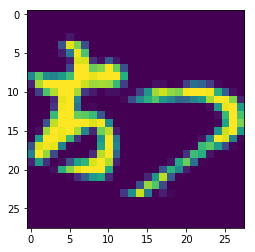

In [20]:
plt.imshow(x_temp[0].view(28,28))
y_temp[0]

## collate function and the new data loader with random sample

(torch.Size([6, 784]), torch.Size([6]))

tensor(0)

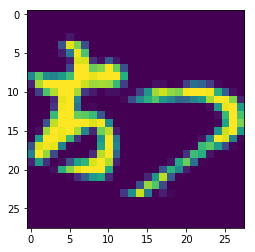

In [29]:
# # Question: not sure why we need to use collate since train_ds[[i1,i2,i3]] is good enough to get batch containing x and y,
# instead of using collate_fn([train_ds[i] for i in [i1,i2,i3]])
# # Answer: so if we want to do something different for each sample in a batch (e.g data augmentation), we can define our own collate function
def collate(b):
    xs,ys = zip(*b)
    # xs is all imgs in that batch (6)
    # perform any data manipulation (augmentation, ...) on xs here
    return torch.stack(xs),torch.stack(ys)
x_temp,y_temp = collate([train_ds[i] for i in b1])
x_temp.shape,y_temp.shape # (torch.Size([6, 784]), torch.Size([6]))
plt.imshow(x_temp[0].view(28,28))
y_temp[0]

In [30]:
# class DataLoader():
#     def __init__(self, ds, sampler, collate_fn=collate):
#         self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
#     def __iter__(self):
#         for s in self.sampler: yield self.ds[s]
class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [31]:
bs=64

In [32]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(2)

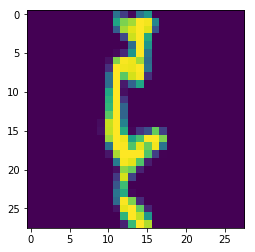

In [33]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [36]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.6373, grad_fn=<NllLossBackward>), tensor(0.7656))

In [37]:
# check train loss
xb_tr,yb_tr = next(iter(train_dl))
loss,acc = loss_func(model(xb_tr), yb_tr), accuracy(model(xb_tr), yb_tr)
assert acc>0.7
loss,acc

(tensor(0.2708, grad_fn=<NllLossBackward>), tensor(0.9219))

# Pytorch DataLoader

In [38]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate) # shuffle true
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)# shuffle false

In [39]:
epochs

1

In [40]:
xb,yb = next(iter(valid_dl))

In [41]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.8562, grad_fn=<NllLossBackward>), tensor(0.7656))

In [42]:
# normal dataloader
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

# New fit function

In [43]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)

        # record loss at each epoch: cummulate val loss for the entire epoch and average out 
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

def get_dataloaders(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [44]:
loss_func

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

In [49]:
lr=0.1

In [50]:
train_dl,valid_dl = get_dataloaders(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.6121) tensor(0.8119)
1 tensor(0.5967) tensor(0.8220)
2 tensor(0.5394) tensor(0.8461)
3 tensor(0.5082) tensor(0.8583)
4 tensor(0.5283) tensor(0.8601)
